In [11]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from IPython.display import HTML

In [12]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
session = tf.InteractiveSession()

In [13]:
class DataDistribution(object):
    def __init__(self):
        self.mu = -1
        self.sigma = 1

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples      


In [14]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01


In [15]:
tf.reset_default_graph()
def mlp(input, h_dim):
    init_const = tf.constant_initializer(0.0)
    init_norm = tf.random_normal_initializer()
    w0 = tf.get_variable('w0', [input.get_shape()[1], h_dim], initializer=init_norm)
    b0 = tf.get_variable('b0', [h_dim], initializer=init_const)
    w1 = tftf.get_variable_scope().get_variable('w1', [h_dim, h_dim], initializer=init_norm)
    b1 = tf.get_variable('b1', [h_dim], initializer=init_const)
    h0 = tf.tanh(tf.matmul(input, w0) + b0)
    h1 = tf.tanh(tf.matmul(h0, w1) + b1)
    return h1, [w0, b0, w1, b1]


def generator(input, h_dim):
    #transform, params = mlp(input, h_dim)
    nn = tf.layers.dense(input, 4, activation=tf.nn.sigmoid)
    transform = tf.layers.dense(nn, 4, activation=tf.nn.sigmoid)
    init_const = tf.constant_initializer(0.0)
    init_norm = tf.random_normal_initializer()
    w = tf.get_variable('g_w', [h_dim, 1], initializer=init_norm)
    b = tf.get_variable('g_b', [1], initializer=init_const)
    h = tf.matmul(transform, w) + b
    return h, [w, b]


def discriminator(input, h_dim):
    #transform, params = mlp(input, h_dim)
    with tf.variable_scope(tf.get_variable_scope(), reuse=False):
        nn = tf.layers.dense(input, 4, activation=tf.nn.sigmoid)
        transform = tf.layers.dense(nn, 4, activation=tf.nn.sigmoid)
        init_const = tf.constant_initializer(0.0)
        init_norm = tf.random_normal_initializer()
        w = tf.get_variable('d_w', [h_dim, 1], initializer=init_norm)
        b = tf.get_variable('d_b', [1], initializer=init_const)
        h = tf.sigmoid(tf.matmul(transform, w) + b)
    return h, [w, b]



In [16]:
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=0.03):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer


In [17]:
def plot_distributions(GAN, session, loss_d, loss_g):
    num_points = 100000
    num_bins = 100
    xs = np.linspace(-GAN.gen.range, GAN.gen.range, num_points)
    bins = np.linspace(-GAN.gen.range, GAN.gen.range, num_bins)

    # p(data)
    d_sample = GAN.data.sample(num_points)

    # decision boundary
    ds = np.zeros((num_points, 1))  # decision surface
    for i in range(num_points // GAN.batch_size):
        ds[GAN.batch_size * i:GAN.batch_size * (i + 1)] = session.run(GAN.D1, {
            GAN.x: np.reshape(xs[GAN.batch_size * i:GAN.batch_size * (i + 1)], (GAN.batch_size, 1))
        })

    # p(generator)
    zs = np.linspace(-GAN.gen.range, GAN.gen.range, num_points)
    gs = np.zeros((num_points, 1))  # generator function
    for i in range(num_points // GAN.batch_size):
        gs[GAN.batch_size * i:GAN.batch_size * (i + 1)] = session.run(GAN.G, {
            GAN.z: np.reshape(
                zs[GAN.batch_size * i:GAN.batch_size * (i + 1)],
                (GAN.batch_size, 1)
            )
        })
           
    anim_frames.append((d_sample, ds, gs, loss_d, loss_g))

## Build GAN ##

In [18]:


class GAN(object):
    def __init__(self, data, gen, num_epochs):
        self.data = data
        self.gen = gen
        self.num_epochs = num_epochs
        self.log_every = 100
        self.anim_frame_every = 5
        self.batch_size = 128
        self.mlp_hidden_size = 4
        self._create_model()

    def _create_model(self):
        # In order to make sure that the discriminator is providing useful gradient
        # information to the generator from the start, we're going to pretrain the
        # discriminator using a maximum likelihood objective. We define the network
        # for this pretraining step scoped as D_pre.
        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D, self.pre_theta = discriminator(self.pre_input, self.mlp_hidden_size)
            self.pre_loss = tf.reduce_mean(tf.square(D - self.pre_labels))
            self.pre_opt = optimizer(self.pre_loss, None, self.num_epochs)
        
        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('G'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G, theta_g = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('D') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1, self.theta_d1 = discriminator(self.x, self.mlp_hidden_size) # discriminator return output, parameters w
            scope.reuse_variables()
            self.D2, self.theta_d2 = discriminator(self.G, self.mlp_hidden_size)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        self.opt_d = optimizer(self.loss_d, self.theta_d2, self.num_epochs)
        self.opt_g = optimizer(self.loss_g, theta_g, self.num_epochs)
    
    def train(self):
        with tf.Session() as sess:
            tf.initialize_all_variables().run()

            # discriminator pretraining
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                pretrain_loss, _ = sess.run([self.pre_loss, self.pre_opt], {
                    self.pre_input: np.reshape(d, (self.batch_size, 1)),
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))
                })
            self.weightsD = sess.run(self.pre_theta)

            # copy weights from pre-training over to new D network
            for i, v in enumerate(self.theta_d2):
                sess.run(v.assign(self.weightsD[i]))

            for step in range(self.num_epochs):
                # update discriminator
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)

                loss_d, _ = sess.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                # update generator
                z = self.gen.sample(self.batch_size)
                loss_g, _ = sess.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                if step % self.log_every == 0:
                    print('{}: {}\t{}'.format(step, loss_d, loss_g))

                if step % self.anim_frame_every == 0:
                    plot_distributions(self, sess, loss_d, loss_g)



## Train it ##

In [19]:
anim_frames = []
num_epochs = 2000
model = GAN(DataDistribution(), GeneratorDistribution(range=8), num_epochs)
model.train()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 1.5912500619888306	1.2663471698760986
100: 1.3457964658737183	0.713416337966919
200: 1.3380639553070068	0.6978693008422852
300: 1.3424268960952759	0.6991408467292786
400: 1.3430109024047852	0.6997749209403992
500: 1.347832202911377	0.6988258361816406
600: 1.364588737487793	0.6965885162353516
700: 1.3704856634140015	0.6941254734992981
800: 1.379626989364624	0.6918670535087585
900: 1.3931374549865723	0.6902443170547485
1000: 1.3946856260299683	0.6889591813087463
1100: 1.405285358428955	0.6883296370506287
1200: 1.4026741981506348	0.6882883310317993
1300: 1.4078248739242554	0.6886296272277832
1400: 1.408859372138977	0.6891969442367554
1500: 1.4090006351470947	0.6901221871376038
1600: 1.413456916809082	0.6910935640335083
1700: 1.4080560207366943	0.6922759413719177
1800: 1.4087941646575928	0.6935615539550781
1900: 1.4063642024993896	0.6948912143707275


In [16]:
len(anim_frames)

300

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


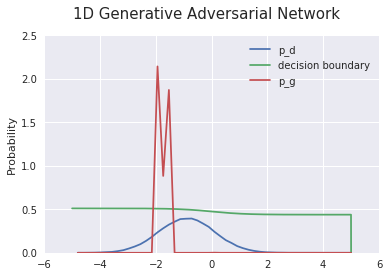

In [26]:
bins = np.linspace(-5, 5, 50)
x = np.linspace(-5, 5, 100000)

f, ax = plt.subplots(figsize=(6,4))
f.suptitle('1D Generative Adversarial Network', fontsize=15)
plt.ylabel('Probability')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 2.5)
line_d, = ax.plot([], [], label='p_d')
line_ds, = ax.plot([], [], label='decision boundary')
line_g, = ax.plot([], [], label='p_g')

histd, _ = np.histogram(anim_frames[299][0], bins=bins, normed=True)
line_d.set_data(bins[1:], histd)

ds = anim_frames[299][1]
line_ds.set_data(x, ds)

histg, _ = np.histogram(anim_frames[299][2], bins=bins, normed=True)
line_g.set_data(bins[1:], histg)

frame_text = ax.text(0.02, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
ax.legend()

In [20]:
print(session.run(a))


array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
       -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
       -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
       -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
       -0.91836735, -0.71428571, -0.51020408, -0.30612245, -0.10204082,
        0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
        1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
        2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
        3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
        4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ])

In [29]:
bins = np.linspace(-5, 5, 50)
x = np.linspace(-5, 5, 100000)

histd, _ = np.histogram(anim_frames[199][0], bins=bins, normed=True)
line_d.set_data(bins[1:], histd)

ds = anim_frames[199][1]
line_ds.set_data(x, ds)

histg, _ = np.histogram(anim_frames[199][2], bins=bins, normed=True)
line_g.set_data(bins[1:], histg)

frame_text.set_text('Timestep = %.1d/%.1d' % (199, len(anim_frames)))

IndexError: list index out of range

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'rc', 'norm', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## отладка##

In [ ]:
tf.reset_default_graph()
_input = tf.placeholder(tf.float32, shape=(128, 1))
nn = tf.layers.dense(_input, 4, activation=tf.nn.sigmoid)
transform = tf.layers.dense(nn, 4, activation=tf.nn.sigmoid)
transform_1, params = mlp(_input, 4)
init_const = tf.constant_initializer(0.0)
init_norm = tf.random_normal_initializer()
w = tf.get_variable('d_w', [4, 1], initializer=init_norm)
b = tf.get_variable('d_b', [1], initializer=init_const)
print ('transform.shape', transform.get_shape)
print ('w.shape', w.get_shape)
print ('b.shape', b.get_shape)
res = tf.matmul(transform, w) + b
print ('res.shape', res.get_shape)